# 02: Monopile 

In this example, we show `Ard` handling gradient computation.

As in Example 01, we start by loading what we need to run the problem.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

# import optiwindnet.plotting

%matplotlib inline

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

Now, we can set up different case.
As before, we do it a little verbosely so that our documentation system can grab it, you can generally just use relative paths.
We grab the file at `inputs/ard_system.yaml`, which describes the `Ard` system for this problem.
It references, in turn, the `inputs/windio.yaml` file, which is where we define the plant we want to optimize, and an initial setup for it.

In [2]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# set up system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


Adding top_level
Adding layout2aep
Adding layout to layout2aep
Adding aepFLORIS to layout2aep
	Activating approximate totals on layout2aep
Adding landuse
Adding collection
Adding spacing_constraint
Adding tcc
Adding orbit
Adding opex
Adding financese


Here, you should see each of the groups or components described as they are added to the `Ard` model and, occasionally, some options being turned on on them.
Comparing to Example 01, you can notice that the balance-of-station cost model (BOS) is different: before it was `landbosse` and now it is `orbit`, and this is so we can generate an estimate for offshore BOS costs.

As before, we leave in some turned-off-by-default code here in case you want to see what the connections of the system look like with an [N2 diagram vizualization](https://openmdao.org/newdocs/versions/latest/features/model_visualization/n2_basics/n2_basics.html).

In [3]:
if False:
    # visualize model
    om.n2(prob)

Here's the one-shot analysis.

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("orbit.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:231: UserWarning:The existing case recorder file, ard_prob_out/problem_out/opt_results.sql, is being overwritten.
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

ORBIT library intialized at '/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/library'


RESULTS:

{'AEP_val': 2491.169182284602,
 'BOS_val': 1269.2092798089284,
 'CapEx_val': 768.4437570425,
 'LCOE_val': 85.63207159146933,
 'OpEx_val': 60.50000000000001,
 'area_tight': 63.234304,
 'coll_length': 47.761107521256534,
 'turbine_spacing': 1.988}





Now, we can optimize!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
As before, we use a four-dimensional rectilinear layout parameterization ($\theta$) as design variables, and constrain the farm such that the turbines are in the boundaries and satisfactorily spaced.
However, the derivatives of AEP with respect to layout variables are known to be non-smooth, and FLORIS doesn't provide analytical derivatives; to use finite differencing we would be adding noise on top of the noise, making useful gradients even harder to detect!
`Ard` is designed to make overcoming this easier, and more about that is in the pipeline, but for now we will avoid the complexities of that discussion.
Instead, we optimize to minimize the cable length here, while 
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \mathrm{LCOE}(\theta, \ldots) \\
\textrm{subject to} \quad & \mathrm{AEP}(\theta, \ldots) > \mathrm{AEP}_{\min} \\
                          & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|0
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'collection.total_length_cables': array([47761.10752126])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|1
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}

Objectives
{'collection.total_length_cables': array([47761.10752126])}



invalid value encountered in divide

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|2
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.00080387]),
 'angle_skew': array([-0.00104343]),
 'spacing_primary': array([6.97160497]),
 'spacing_secondary': array([6.94320903])}

Objectives
{'collection.total_length_cables': array([47422.44976731])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|3
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([-0.02013307]),
 'angle_skew': array([-0.03367621]),
 'spacing_primary': array([6.85288012]),
 'spacing_secondary': array([6.59919383])}

Objectives
{'collection.total_length_cables': array([45461.68266391])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|4
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([-0.13933268]),
 'angle_skew': array([-0.19339181]),
 'spacing_primary': array([6.2

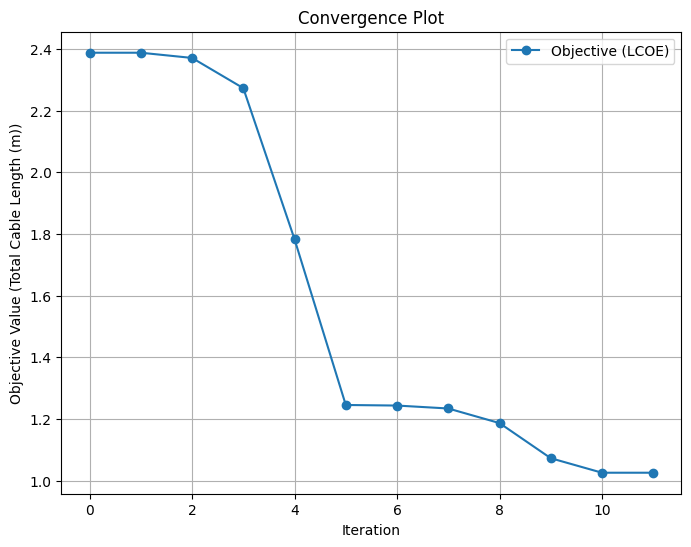

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("orbit.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")
    # plot convergence
    ## read cases
    cr = om.CaseReader(
        prob.get_outputs_dir() / input_dict["analysis_options"]["recorder"]["filepath"]
    )

    # Extract the driver cases
    cases = cr.get_cases("driver")

    # Initialize lists to store iteration data
    iterations = []
    objective_values = []

    # Loop through the cases and extract iteration number and objective value
    for i, case in enumerate(cases):
        iterations.append(i)
        objective_values.append(
            case.get_objectives()[input_dict["analysis_options"]["objective"]["name"]]
        )

    # Plot the convergence
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, objective_values, marker="o", label="Objective (LCOE)")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value (Total Cable Length (m))")
    plt.title("Convergence Plot")
    plt.legend()
    plt.grid()
    plt.show()

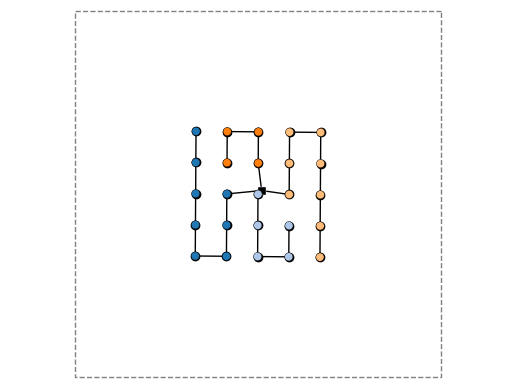

In [6]:
plot_layout(
    prob,
    input_dict=input_dict,
    show_image=True,
    include_cable_routing=True,
)
plt.show()